In [71]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
import numpy as np
import lavavu
import matplotlib.pyplot as plt
import pandas as pd
import logging
logging.getLogger().setLevel(logging.INFO)
%matplotlib inline

In [72]:
dips = pd.read_csv('../Dips.csv',delimiter=';')
points_file_names = ['../APoints.csv','../BPoints.csv','../CPoints.csv','../DPoints.csv']
section_file_names = ['../ASection.csv','../BSection.csv','../CSection.csv','../DSection.csv']

# import all of the csv into the same dataframe
dfs = []
for f in points_file_names:
    dfs.append(pd.read_csv(f,delimiter=';'))
points = pd.concat(dfs,axis=0,ignore_index=True)
# sections
dfs = []
for f in section_file_names:
    dfs.append(pd.read_csv(f,delimiter=';'))
sections = pd.concat(dfs,axis=0,ignore_index=True)
# apoints = pd.read_csv('APoints.csv',delimiter=';')
# asection = pd.read_csv('ASection.csv',delimiter=';')
dips = dips.rename(columns={'OrientX':'nx','OrientY':'ny','OrientZ':'nz'})

sections = sections.rename(columns={'Strati':'val'})
points = points.rename(columns={'Strati':'val'})

In [73]:
data = pd.concat([points,sections,dips],sort=False)
data['type'] = 'strati'

In [74]:
solvers = ['lu']#,'lu','cg','lsqr']
elements = [1000,5000,10000]#,15000,30000,50000,100000,200000,300000]

In [75]:
from LoopStructural.datasets import load_claudius
data, bb = load_claudius()
print(bb)

[[ 548800. 7816600.  -11010.]
 [ 552500. 7822000.   -8400.]]


In [76]:
origin = (548800, 7816600, -8400,)
nsteps = np.array((38,55,30))
step_vector = (100,100,-90)
maximum = origin+nsteps*step_vector

## Using Piecewise linear with 1e5 elements

In [77]:
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(data)
results = {}
strati = model.create_and_add_foliation("strati", 
                                           interpolatortype="PLI",
                                           nelements=1e5,
                                           buffer=0.5,
                                           solver='pyamg',
#                                            damp=True,
                                       )
#             model.features = []

Pyamg not installed using cg instead



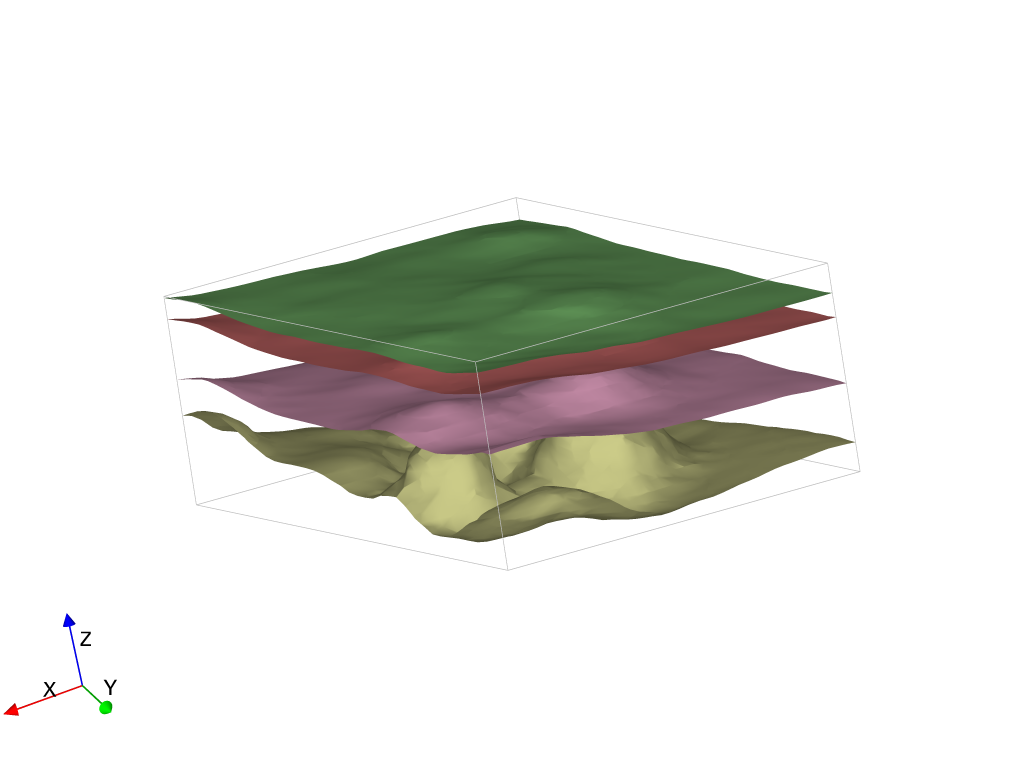

In [78]:
viewer = LavaVuModelViewer(model)
slices = data['val'].unique()

viewer.add_isosurface(strati,
                      slices=slices[~np.isnan(slices)] ,
                      paint_with=strati,
                      cmap='tab20'
                     )
# viewer.add_isosurface(strati,
#                       slices=[335,340,350,355,360] ,
#                       paint_with=strati,
#                       cmap='tab20'
#                      )
# viewer.add_data(strati)
viewer.rotation = [75.99015045166016, -28.587671279907227, -164.32925415039062]
viewer.display('claudius_pli_1e5.png')
# viewer.interactive()


In [80]:
import re
def read_voxet(voxetname,propertyfile):
    """
    Read a gocad property file and the geometry information from the .vo file
    voxetname - is the path to the voxet file
    propertyfile is the path to the binary file
    Returns
    origin numpy array
    voxet_extent - is the length of each axis of the voxet
    N is the number of steps in the voxet
    array is the property values
    steps is the size of the step vector for the voxet 
    """
    array = np.fromfile(propertyfile,dtype='float32')
    array = array.astype('<f4') # little endian
    with open(voxetname,'r') as file:
        for l in file:
            if 'AXIS_O ' in l:
                origin = np.array(re.findall(r"[-+]?\d*\.?\d+|[-+]?\d+",l)).astype(float)
            if 'AXIS_U ' in l:
                U = float(re.findall(r'[\d\.\d]+',l)[0])
            if 'AXIS_V ' in l:
                V = float(re.findall(r'[\d\.\d]+',l)[1])
            if 'AXIS_W ' in l:
                W = float(re.findall(r'[\d\.\d]+',l)[2])
            if 'AXIS_N ' in l:
                N = np.array(re.findall(r'[\d\.\d]+',l)).astype(int) 
    voxet_extent = np.array([U,V,W])
    steps = (voxet_extent ) / (N-1)
    return origin, voxet_extent, N, array, steps

def write_property_to_gocad_voxet(propertyfilename, propertyvalues):
    """
    This function writes a numpy array into the right format for a gocad
    voxet property file. This assumes there is a property already added to the .vo file,
    and is just updating the file.
    propertyfile - string giving the path to the file to write
    propertyvalues - numpy array nz,ny,nx ordering and in float format
    """
    propertyvalues = propertyvalues.astype('>f4') #big endian
#     array = propertyvalues.newbyteorder()
    propertyvalues.tofile(propertyfilename)

In [81]:
#from LoopStructural.utils.utils import write_property_to_gocad_voxet, read_voxet
origin, voxet_extent, N, array, steps = read_voxet('Box.vo','ResultsLoopStructural_result@@')
x = np.linspace(bb[0,0],bb[1,0],N[0])
y = np.linspace(bb[0,1],bb[1,1],N[1])
z = np.linspace(bb[0,2],bb[1,2],N[2])

xx, yy, zz = np.meshgrid(x,y,z,indexing='ij')
eval_points = model.scale(np.array([xx.flatten(order='F'),yy.flatten(order='F'),zz.flatten(order='F')]).T)
vals = strati['feature'].evaluate_value(eval_points)
vals2 = vals.reshape((N[2],N[1],N[0]))
write_property_to_gocad_voxet('ResultsLoopStructural_result_PLI_1e5@@',vals2.flatten(order='C'))

## Using Finite Difference with 2e4 elements
This is the same number of DOF as PLI with 1e5 because 5 elements per tetra for PLI

In [82]:
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(data)
results = {}
strati = model.create_and_add_foliation("strati", 
                                           interpolatortype="FDI",
                                           nelements=1e5/5,
                                           buffer=0.5,
                                           solver='pyamg',
#                                            damp=True,
                                       )
#             model.features = []

Pyamg not installed using cg instead



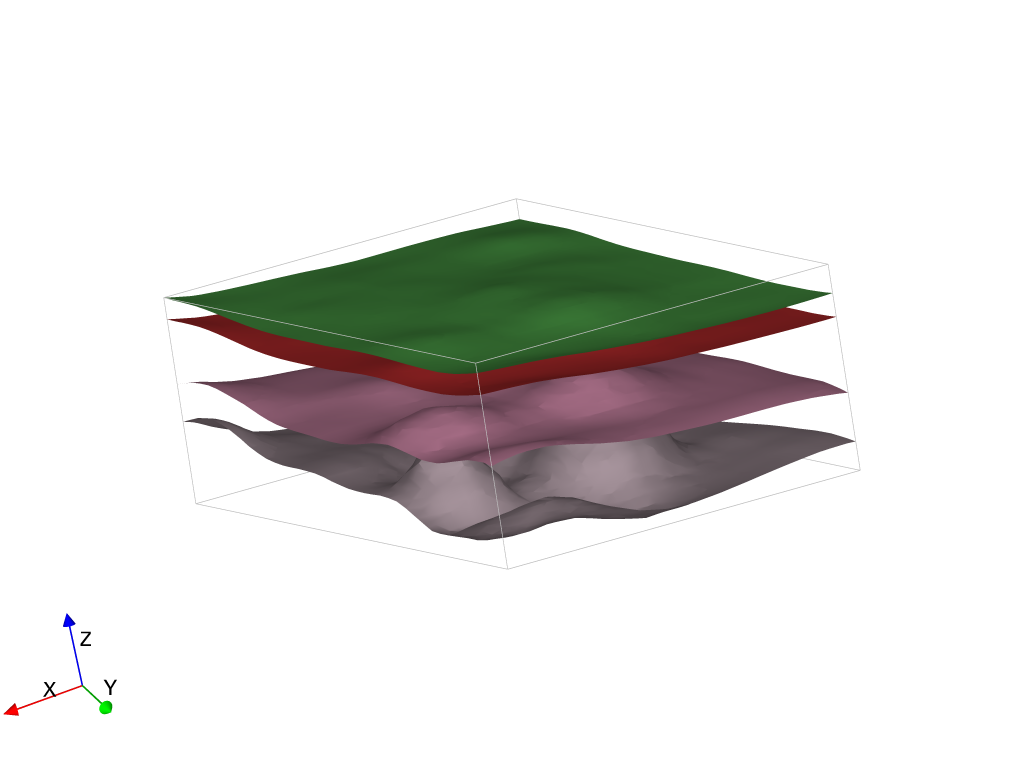

In [83]:
viewer = LavaVuModelViewer(model)
slices = data['val'].unique()

viewer.add_isosurface(strati,
                      slices=slices[~np.isnan(slices)] ,
                      paint_with=strati,
                      cmap='tab20'
                     )
# viewer.add_isosurface(strati,
#                       slices=[335,340,350,355,360] ,
#                       paint_with=strati,
#                       cmap='tab20'
#                      )
# viewer.add_data(strati)
viewer.rotation = [75.99015045166016, -28.587671279907227, -164.32925415039062]
viewer.display('claudius_fdi_2e4.png')


In [85]:
#from LoopStructural.utils.utils import write_property_to_gocad_voxet, read_voxet
origin, voxet_extent, N, array, steps = read_voxet('Box.vo','ResultsLoopStructural_result@@')
x = np.linspace(bb[0,0],bb[1,0],N[0])
y = np.linspace(bb[0,1],bb[1,1],N[1])
z = np.linspace(bb[0,2],bb[1,2],N[2])

xx, yy, zz = np.meshgrid(x,y,z,indexing='ij')
eval_points = model.scale(np.array([xx.flatten(order='F'),yy.flatten(order='F'),zz.flatten(order='F')]).T)
vals = strati['feature'].evaluate_value(eval_points)
vals2 = vals.reshape((N[2],N[1],N[0]))
write_property_to_gocad_voxet('ResultsLoopStructural_result_FDI_2e4@@',vals2.flatten(order='C'))